In [7]:
%load_ext autoreload
%autoreload 2

import json
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
with open("../results/alignment_tax_v1.03.json", "r") as f:
# with open("../results/alignment_tax_v1.01.json", "r") as f:
    results = json.load(f)

results["meta"]

{'model_name': 'meta-llama/Llama-2-7b-chat-hf',
 'layer': 29,
 'batch_size': 1,
 'max_seq_length': 4096,
 'total_tokens_per_batch': 100000,
 'injection_coefficients': [0, 20, 40, 75, 100, 150, 200, 250, 300, 400, 500],
 'note': 'Random activations, more ics and bfloat16'}

In [21]:
#TODO: really messy code, should work on changing the structuring of the results
accs = {}
modes = ("only_text", "only_code")
injection_coefficients = list(results["only_code"].keys())
metrics = ("top1_acc", "top10_acc", "skip50_top1_acc", "skip50_top10_acc")


for mode in modes:
    accs[mode] = {}
    for metric in metrics:
        accs[mode][metric] = [0]*len(injection_coefficients), [0]*len(injection_coefficients)
    
    for i, ic in enumerate(injection_coefficients):
        keys_batches = results[mode][ic].keys()
        for batch in keys_batches:
            for metric in metrics:
                accs[mode][metric][0][i] += results[mode][ic][batch][metric]
                accs[mode][metric][1][i] += 1

avg_scores_dict = {mode: {} for mode in modes}
relative_scores_dict = {mode: {} for mode in modes}

for mode in modes:
    for metric in metrics:
    # for metric in ["skip50_top10_acc"]:
        sum_scores, counts = accs[mode][metric]
        avg_scores = [sum_score / count *100 for sum_score, count in zip(sum_scores, counts)]
        relative_scores = [avg_score / avg_scores[0] *100 for avg_score in avg_scores]
        avg_scores_dict[mode][metric] = avg_scores
        relative_scores_dict[mode][metric] = relative_scores
        # print(f"\n\nMetric: {metric}")
        # print(f"avg_score: {avg_scores}\n")
        # print(f"relative_scores: {relative_scores}")

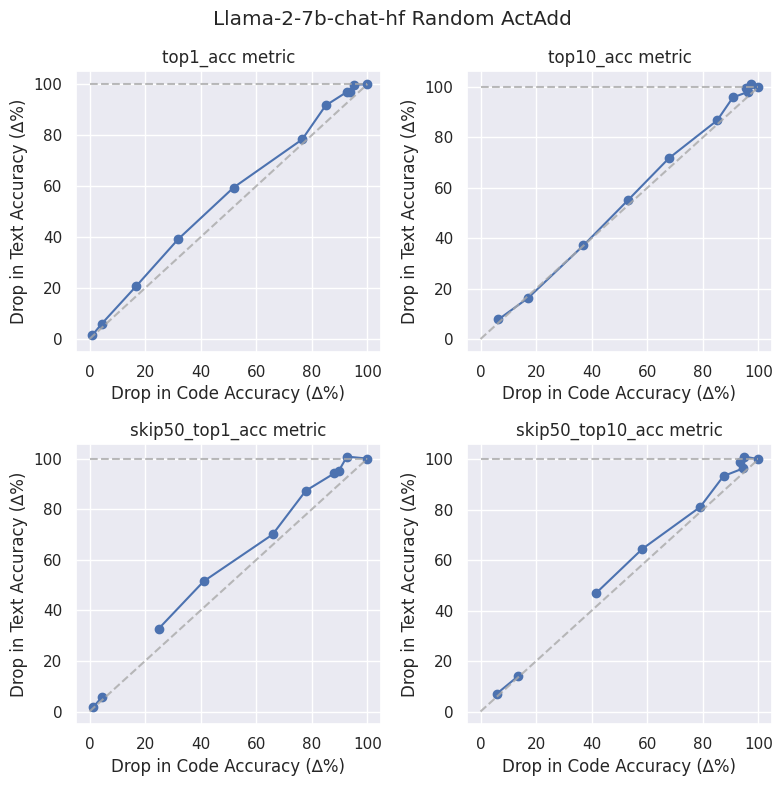

In [32]:
# create a seaborn style graph
sns.set_theme()

fig, axs = plt.subplots(2, 2, figsize=(8,8))
scale = 100

for metric, ax in zip(metrics, axs.reshape(-1)):
    ax.plot(relative_scores_dict["only_code"][metric], relative_scores_dict['only_text'][metric], marker="o")
    ax.set_title(f"{metric} metric")
    ax.set_xlabel("Drop in Code Accuracy (∆%)")
    ax.set_ylabel("Drop in Text Accuracy (∆%)")

    ax.plot([0, scale], [scale, scale], color="darkgray", linestyle="--", alpha=0.8)
    ax.plot([0, scale], [0,     scale], color="darkgray", linestyle="--", alpha=0.8)

title = results["meta"]["model_name"].split("/")[1] + " Random ActAdd"
plt.suptitle(title)
fig.tight_layout()
plt.show()

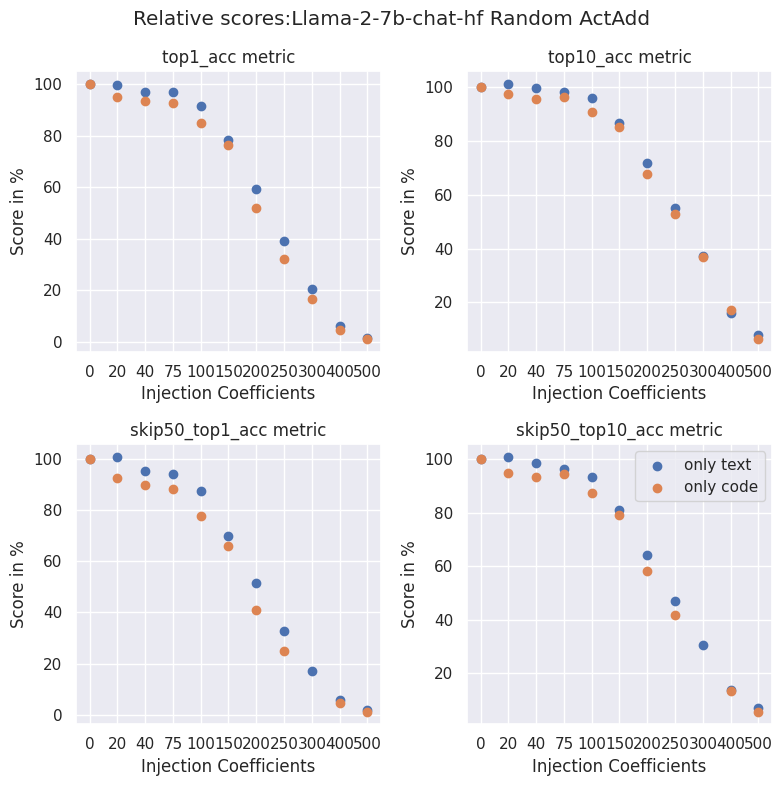

In [23]:
# create a seaborn style graph
sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(8,8))
scale = 100
ic_ints = [ic.split("_")[2] for ic in injection_coefficients]

for metric, ax in zip(metrics, axs.reshape(-1)):
    ax.scatter(ic_ints, relative_scores_dict['only_text'][metric], label="only text")
    ax.scatter(ic_ints, relative_scores_dict['only_code'][metric], label="only code")

    ax.set_title(f"{metric} metric")
    ax.set_xlabel("Injection Coefficients")
    ax.set_ylabel("Score in %")

plt.legend()
plt.suptitle("Relative scores:" + title)
fig.tight_layout()
plt.show() 

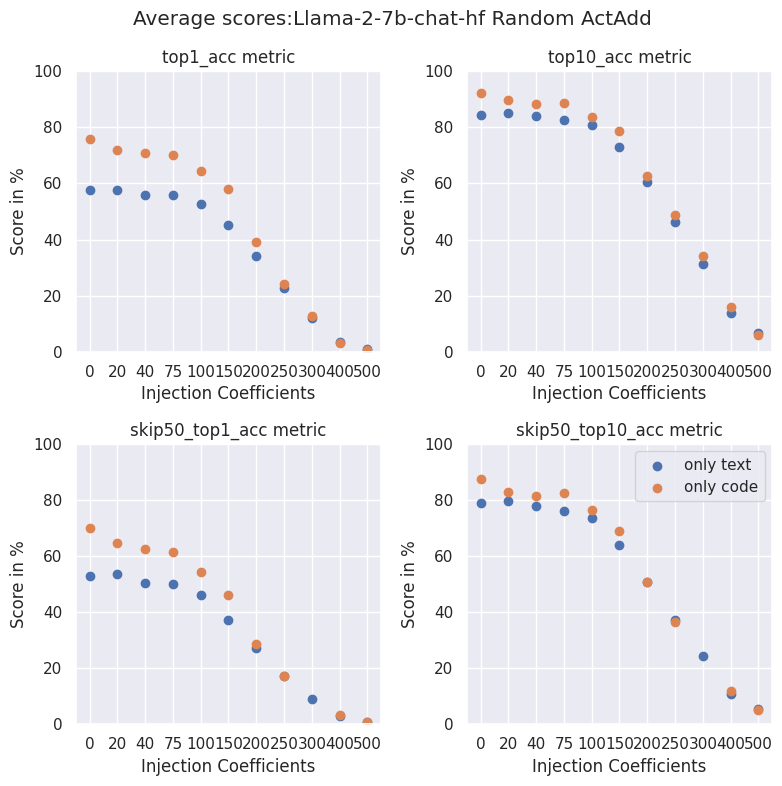

In [31]:
# create a seaborn style graph
sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(8,8))#, sharex=True, sharey=True)
scale = 100
ic_ints = [ic.split("_")[2] for ic in injection_coefficients]

for metric, ax in zip(metrics, axs.reshape(-1)):
    # ax.set_xticks([0, 20, 40, 60, 80, 100])#, labels=["0", "20" "40", "60", "80", "100"])
    # ax.set_yticks([0, 20, 40, 60, 80, 100])
    # ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])

    ax.scatter(ic_ints, avg_scores_dict['only_text'][metric], label="only text")
    ax.scatter(ic_ints, avg_scores_dict['only_code'][metric], label="only code")

    ax.set_title(f"{metric} metric")

    ax.set_xlabel("Injection Coefficients")
    ax.set_ylabel("Score in %")
    
plt.legend()
plt.suptitle("Average scores:" + title)
fig.tight_layout()
plt.show()

In [35]:
with open("../results/alignment_tax_v1.02.json", "r") as f:
    f16_results = json.load(f)

with open("../results/alignment_tax_v1.03.json", "r") as f:
    bf16_results = json.load(f)

f16_results['meta'], bf16_results['meta']

({'model_name': 'meta-llama/Llama-2-7b-chat-hf',
  'layer': 29,
  'batch_size': 1,
  'max_seq_length': 4096,
  'total_tokens_per_batch': 100000,
  'injection_coefficients': [0, 5, 20, 30, 40, 50, 75, 100, 150, 200, 300],
  'note': 'Random activations'},
 {'model_name': 'meta-llama/Llama-2-7b-chat-hf',
  'layer': 29,
  'batch_size': 1,
  'max_seq_length': 4096,
  'total_tokens_per_batch': 100000,
  'injection_coefficients': [0, 20, 40, 75, 100, 150, 200, 250, 300, 400, 500],
  'note': 'Random activations, more ics and bfloat16'})

In [37]:
#TODO: really messy code, should work on changing the structuring of the results
f16_speeds, bf16_speeds = [], []
modes = ("only_text", "only_code")
f16_ics = list(f16_results["only_code"].keys())
bf16_ics = list(bf16_results["only_code"].keys())

for mode in modes:
    accs[mode] = {}
    
    for ic in f16_ics:
        keys_batches = f16_results[mode][ic].keys()
        for batch in keys_batches:
            f16_speeds.append(f16_results[mode][ic][batch]["total_time_in_sec"])

    for ic in bf16_ics:
        keys_batches = bf16_results[mode][ic].keys()
        for batch in keys_batches:
            bf16_speeds.append(bf16_results[mode][ic][batch]["total_time_in_sec"])

In [41]:
def avg_speed(x):
    return sum(x) / len(x)

print(f"f16 avg speed: {avg_speed(f16_speeds)}")
print(f"bf16 avg speed: {avg_speed(bf16_speeds)}")

f16 avg speed: 0.17110445615716316
bf16 avg speed: 0.18862386200287454
